In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import models,layers

import warnings

In [26]:
Image_size = 256
CHANNELS=3
Batch_size = 32
Ephocs =20

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size= Batch_size,
    )

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

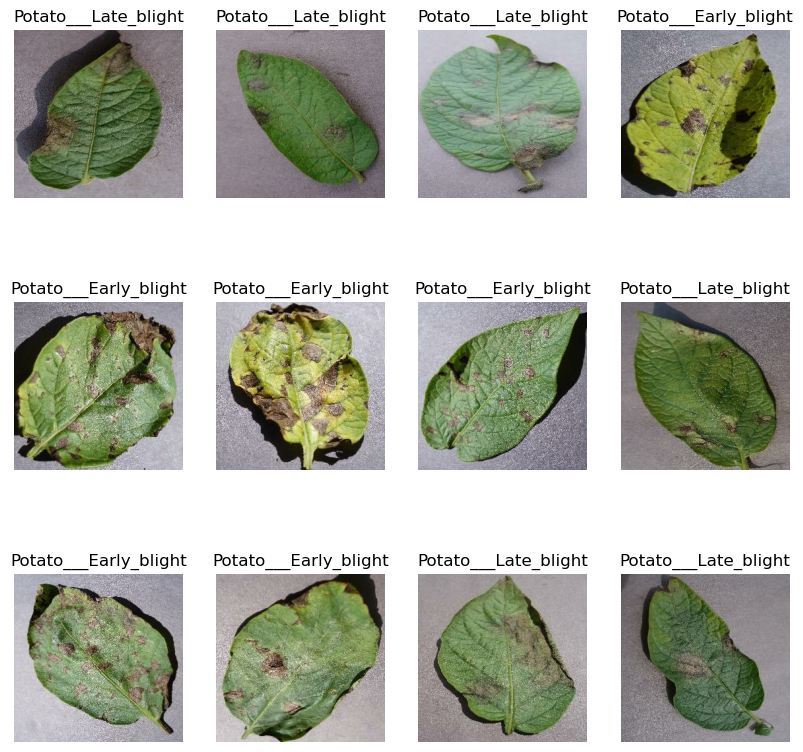

In [5]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("OFF")

In [6]:
len(dataset)

68

In [7]:
train_size = 0.8
len(dataset)*0.8

54.400000000000006

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, valid_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(valid_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [10]:
len(val_ds)

6

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Data Augmentation

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(Image_size, Image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [13]:
Data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


# CNN

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (Batch_size, Image_size, Image_size, CHANNELS)
n_classes = 3

model = keras.Sequential([
    resize_and_rescale,
    Data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =False),
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs=Ephocs,
    batch_size = Batch_size,
    verbose =1,
    validation_data =val_ds
)

Epoch 1/20
54/54 [==============================] - 80s 1s/step - loss: 0.9053 - accuracy: 0.4728 - val_loss: 0.9646 - val_accuracy: 0.5521
Epoch 2/20
54/54 [==============================] - 73s 1s/step - loss: 0.6937 - accuracy: 0.6858 - val_loss: 0.4467 - val_accuracy: 0.7812
Epoch 3/20
54/54 [==============================] - 78s 1s/step - loss: 0.3859 - accuracy: 0.8385 - val_loss: 0.3581 - val_accuracy: 0.8490
Epoch 4/20
54/54 [==============================] - 78s 1s/step - loss: 0.3162 - accuracy: 0.8750 - val_loss: 0.3505 - val_accuracy: 0.8750
Epoch 5/20
54/54 [==============================] - 73s 1s/step - loss: 0.2305 - accuracy: 0.9016 - val_loss: 0.1799 - val_accuracy: 0.9323
Epoch 6/20
54/54 [==============================] - 74s 1s/step - loss: 0.1968 - accuracy: 0.9248 - val_loss: 0.1733 - val_accuracy: 0.9271
Epoch 7/20
54/54 [==============================] - 82s 2s/step - loss: 0.1802 - accuracy: 0.9248 - val_loss: 0.2392 - val_accuracy: 0.9115
Epoch 8/20
54/54 [==

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 246ms/step - loss: 0.5472 - accuracy: 0.8516


In [19]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Valid and trainging')

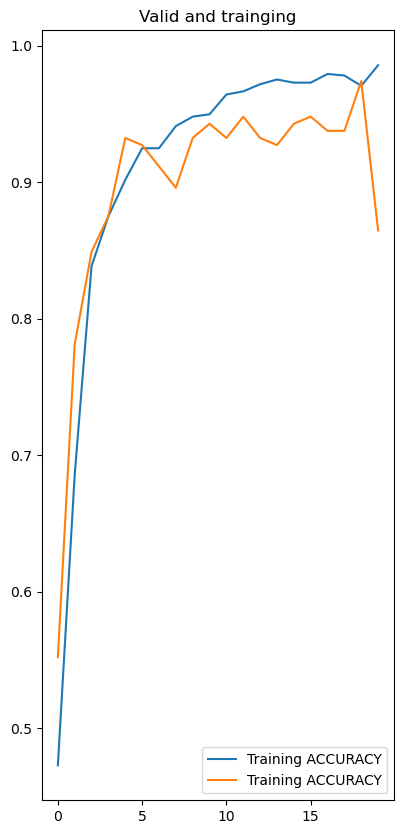

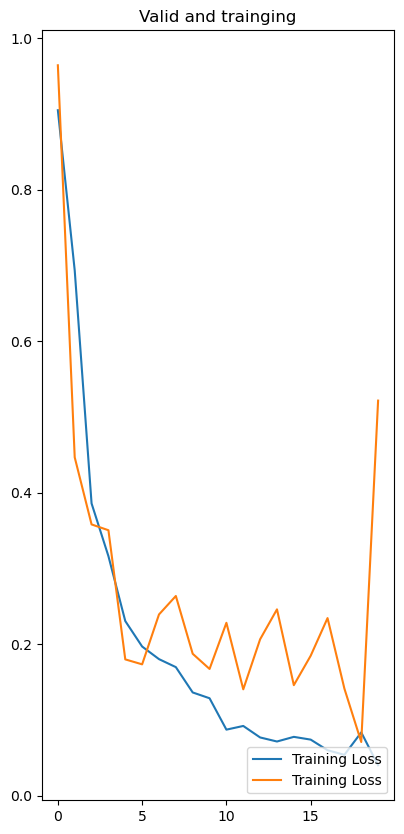

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(Ephocs),acc,label ="Training ACCURACY")
plt.plot(range(Ephocs),val_accuracy,label ="Training ACCURACY")
plt.legend(loc='lower right')
plt.title('Valid and trainging')

plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.plot(range(Ephocs),loss,label ="Training Loss")
plt.plot(range(Ephocs),val_loss,label ="Training Loss")
plt.legend(loc='lower right')
plt.title('Valid and trainging')



first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 490ms/step
predicted label: Potato___Late_blight


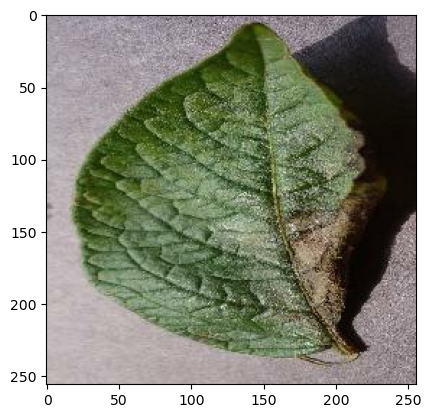

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 47ms/step


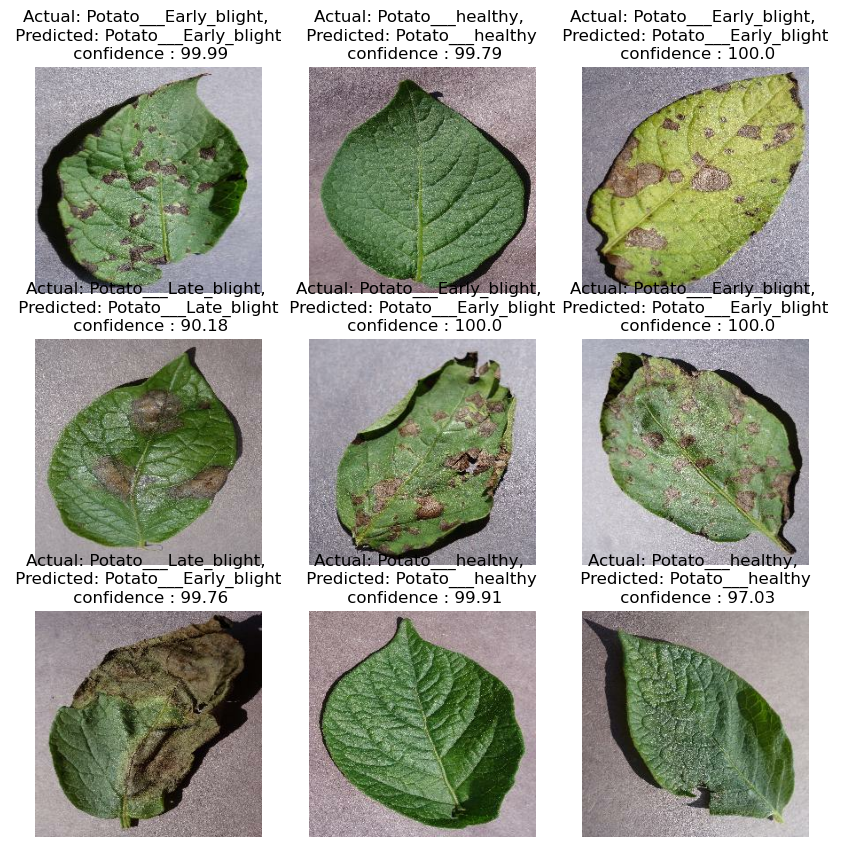

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n confidence : {confidence}")
        plt.axis("off")


In [25]:
import os
model_version =max([int(i) for i in os.listdir("../models")+[0]])+1

model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
